# Yelp Dataset Analysis - Pub Ratings

In [164]:
import csv
import pandas as pd
import numpy as np
import pandas as pd
import seaborn as sns
import operator #need this for sorting dicts later
import matplotlib.cm as cm #for colormapping later
from matplotlib.colors import LogNorm
import matplotlib as mpl
import matplotlib.pyplot as plt
import math
%matplotlib inline

Import custom restauramt and not_restaurant csv files as dataframes

In [165]:
not_restaurant_df = pd.read_csv('not_restaurant.csv')
not_restaurant_df = not_restaurant_df.drop(['Unnamed: 0','city','distance'], 1)
not_restaurant_df = not_restaurant_df.drop_duplicates(subset=['name','postal_code','latitude','longitude','neighborhood'], keep=False)

pubs_df = pd.read_csv('pubs.csv')
pubs_df = pubs_df.drop(['city','Unnamed: 0'], 1)
pubs_df = pubs_df.drop_duplicates(subset=['name','postal_code','latitude','longitude','neighborhood'], keep=False)
pubs_df['index_no'] = pubs_df.index
pubs_df.head()

not_pubs_df = pd.read_csv('not_pubs.csv')
not_pubs_df = not_pubs_df.drop(['city','Unnamed: 0'], 1)
not_pubs_df = not_pubs_df.drop_duplicates(subset=['name','postal_code','latitude','longitude','neighborhood'], keep=False)
not_pubs_df['index_no'] = not_pubs_df.index
not_pubs_df.head()

toronto_businesses_df = pd.read_csv('toronto_businesses.csv')
toronto_businesses_df = toronto_businesses_df.drop(['city','Unnamed: 0'], 1)
toronto_businesses_df = toronto_businesses_df.drop_duplicates(subset=['name','postal_code','latitude','longitude','neighborhood'], keep=False)
toronto_businesses_df['index_no'] = toronto_businesses_df.index
toronto_businesses_df.head()

,name,postal_code,latitude,longitude,neighborhood,categories,stars,review_count,index_no
0,The Tea Emporium,M4K 1N7,43.677126,-79.353285,Riverdale,"[u'Food', u'Coffee & Tea']",4.5,7,0
1,Hart House Theatre,M5S 3H3,43.663669,-79.394687,University of Toronto,"[u'Arts & Entertainment', u'Performing Arts']",4.0,8,1
2,McCarthy's Irish Pub,M4L 2B5,43.678049,-79.314774,Upper Beach,"[u'Pubs', u'Restaurants', u'Bars', u'Irish', u...",4.0,5,2
3,Paris Bakery & Pastry,M6H 3Z5,43.662401,-79.444706,Wallace Emerson,"[u'Bakeries', u'Food']",3.0,16,3
4,Oishi Sushi,M3J 2G5,43.763510,-79.490750,NaN,"[u'Asian Fusion', u'Restaurants', u'Sushi Bars']",2.0,27,4


In [166]:
not_restaurant_df.describe()

,latitude,longitude,stars,review_count
count,3738.000000,3738.000000,3738.000000,3738.000000
mean,43.659746,-79.390947,3.702381,12.928571
std,0.863939,0.454143,0.979130,24.914754
min,-9.095137,-79.653939,1.000000,3.000000
25%,43.649911,-79.419545,3.000000,4.000000
50%,43.662539,-79.395460,4.000000,6.000000
75%,43.680457,-79.378843,4.500000,13.000000
max,43.844762,-51.833829,5.000000,530.000000


In [167]:
pubs_df.describe()

,latitude,longitude,stars,review_count,index_no
count,203.000000,203.000000,203.000000,203.000000,203.000000
mean,43.668998,-79.388099,3.391626,63.502463,186.078818
std,0.032415,0.057959,0.580695,101.331891,90.279454
min,43.599790,-79.603882,2.000000,3.000000,0.000000
25%,43.650502,-79.414682,3.000000,16.500000,112.500000
50%,43.660418,-79.390206,3.500000,33.000000,187.000000
75%,43.673362,-79.363302,4.000000,71.500000,269.500000
max,43.796148,-79.170583,4.500000,1087.000000,347.000000


In [168]:
final_businesses_df = pd.DataFrame()

def haversine(x):
    
    global not_restaurant_df
    global final_businesses_df
    
    
    # Initialize empty DataFrame
    df = pd.DataFrame()
    measure_1 = pd.DataFrame()
    
    # Calculate the latitudes, longitudes:
    df['LAT_rad'], df['LON_rad'] = np.radians(not_restaurant_df['latitude']), np.radians(not_restaurant_df['longitude'])
    df['dLON'] = df['LON_rad'] - math.radians(x['longitude'])
    df['dLAT'] = df['LAT_rad'] - math.radians(x['latitude'])

    # Use Haversine's formula
    not_restaurant_df['distance'] = 6367 * 2 * np.arcsin(np.sqrt(np.sin(df['dLAT']/2)**2 + math.cos(math.radians(37.2175900)) * np.cos(df['LAT_rad']) * np.sin(df['dLON']/2)**2))
   
    
    # Only consider pubs within a distance of 1 km of the chosen pub
    measure_1 = not_restaurant_df
    measure_1 = measure_1.loc[(not_restaurant_df['distance'] > 0.0) & (not_restaurant_df['distance'] <=1.5)]
    
    
    # Calculate the mean rating of the surrounding pubs
    mean_rating = measure_1['stars'].mean()
    density = (measure_1['stars'].count())/ (2*math.pi*1.0*1.0)

    final_businesses_df = final_businesses_df.append({'name': x['name'].item(), 'rating': x['stars'].item(), 'mean_business_rating': mean_rating, "density": density}, ignore_index=True)
    return final_businesses_df


for line in pubs_df['index_no']:
    x = pubs_df.loc[pubs_df['index_no'] == line]
    haversine(x)


## Relationship Between Pub Rating and Non Pub Business Density

We are interested in looking at the relationship between pub ratings and the density of non pub businesses around each pub. To further divide our dataset, we say that any area with less than or equal to 30 businesses are low density areas while anything above 30 businesses are high density areas.

In [169]:
## Initialize a DF to store pubs that have a density of less than or equal to
## 30 non-pub and non-restaurant businesses around them
low_density_df = pd.DataFrame()
low_density_df = final_businesses_df.loc[final_businesses_df['density'] <= 30]

In [170]:
## Initialize a DF to store pubs that have a density of more than
## 30 non-pub and non-restaurant businesses around them
high_density_df = pd.DataFrame()
high_density_df = final_businesses_df.loc[final_businesses_df['density'] > 30]

Now we can generate a scatterplot with density of non-pub businesses on the x axis and the ratings of pubs on the Y axis to see if any relationship exists.

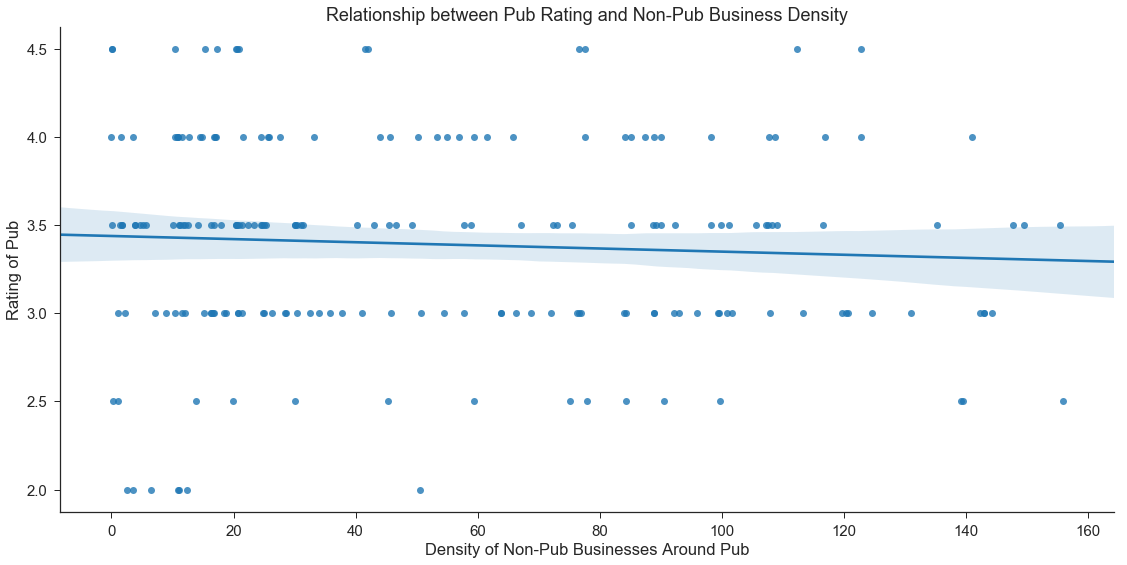

In [171]:
#Set style
sns.set_context("notebook", font_scale=1.5)
sns.set_style("ticks")

# Plot Data
g = sns.lmplot(x="density", y="rating", size=8, data=final_businesses_df,aspect=2.0)

# Plot Labels
plt.title("Relationship between Pub Rating and Non-Pub Business Density")
plt.xlabel('Density of Non-Pub Businesses Around Pub')
plt.ylabel('Rating of Pub')

It seems from the above graph that there is no definite relationship between ratings of pubs and density of businesses. Infact. there seem to be more higher and lower rating pubs in low density areas as compared to high density areas in Toronto.

## Rating of a Pub Based on the Ratings of Other Pubs Around It

In [172]:
final_pubs_df = pd.DataFrame()

def haversine(x):
    
    global pubs_df
    global final_pubs_df
    
    # Initialize empty DataFrame
    df = pd.DataFrame()
    measure_1 = pd.DataFrame()
        
    # Calculate the latitudes, longitudes:
    df['LAT_rad'], df['LON_rad'] = np.radians(pubs_df['latitude']), np.radians(pubs_df['longitude'])
    df['dLON'] = df['LON_rad'] - math.radians(x['longitude'])
    df['dLAT'] = df['LAT_rad'] - math.radians(x['latitude'])

    # Use Haversine's formula
    pubs_df['distance'] = 6367 * 2 * np.arcsin(np.sqrt(np.sin(df['dLAT']/2)**2 + math.cos(math.radians(37.2175900)) * np.cos(df['LAT_rad']) * np.sin(df['dLON']/2)**2))
   
    # Only consider pubs within a distance of 1 km of the chosen pub
    measure_1 = pubs_df
    measure_1 = measure_1.loc[(pubs_df['distance'] > 0) & (pubs_df['distance'] <=1.5)]
    
    # Calculate the mean rating of the surrounding pubs
    mean_rating = measure_1['stars'].mean()
    density = (measure_1['stars'].count())/ (2*math.pi*1.0*1.0)

    final_pubs_df = final_pubs_df.append({'name': x['name'].item(), 'rating': x['stars'].item(), 'mean_business_rating': mean_rating, "density": density}, ignore_index=True)
    return final_pubs_df


for line in pubs_df['index_no']:
    x = pubs_df.loc[pubs_df['index_no'] == line]
    haversine(x)




In [173]:
final_pubs_df = final_pubs_df.fillna(value=0)

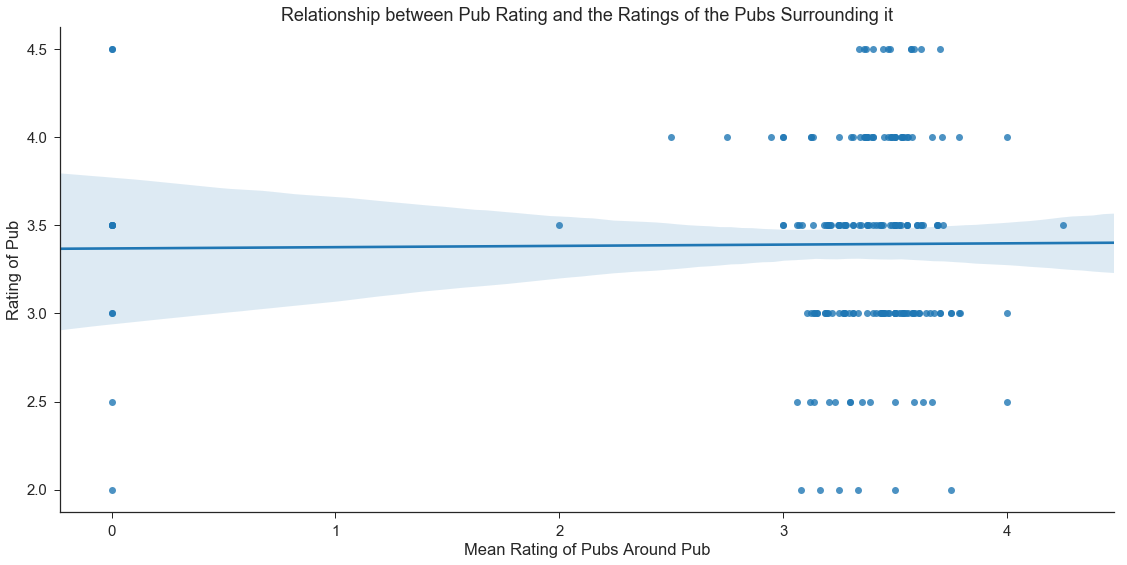

In [174]:
#Set style
sns.set_context("notebook", font_scale=1.5)
sns.set_style("ticks")

# Plot Data
g = sns.lmplot(x="mean_business_rating", y="rating", size=8, data=final_pubs_df,aspect=2.0)

# Plot Labels
plt.title("Relationship between Pub Rating and the Ratings of the Pubs Surrounding it")
plt.xlabel('Mean Rating of Pubs Around Pub')
plt.ylabel('Rating of Pub')

## Ratings of Pubs Based on Ratings of Non-Pub Businesses

In [ ]:
final_nonpubs_df = pd.DataFrame()

def haversine(x):
    
    global not_pubs_df
    global final_nonpubs_df
    
    # Initialize empty DataFrame
    df = pd.DataFrame()
    measure_1 = pd.DataFrame()
        
    # Calculate the latitudes, longitudes:
    df['LAT_rad'], df['LON_rad'] = np.radians(not_pubs_df['latitude']), np.radians(not_pubs_df['longitude'])
    df['dLON'] = df['LON_rad'] - math.radians(x['longitude'])
    df['dLAT'] = df['LAT_rad'] - math.radians(x['latitude'])

    # Use Haversine's formula
    not_pubs_df['distance'] = 6367 * 2 * np.arcsin(np.sqrt(np.sin(df['dLAT']/2)**2 + math.cos(math.radians(37.2175900)) * np.cos(df['LAT_rad']) * np.sin(df['dLON']/2)**2))
   
    # Only consider pubs within a distance of 1 km of the chosen pub
    measure_1 = not_pubs_df
    measure_1 = measure_1.loc[(not_pubs_df['distance'] > 0.0) & (not_pubs_df['distance'] <=1.5)]
    
    # Calculate the mean rating of the surrounding pubs
    mean_rating = measure_1['stars'].mean()
    density = (measure_1['stars'].count())/ (2*math.pi*1.0*1.0)

    final_nonpubs_df = final_nonpubs_df.append({'name': x['name'].item(), 'rating': x['stars'].item(), 'mean_business_rating': mean_rating, "density": density}, ignore_index=True)
    return final_nonpubs_df


for line in pubs_df['index_no']:
    x = pubs_df.loc[pubs_df['index_no'] == line]
    haversine(x)


In [177]:
final_nonpubs_df = final_nonpubs_df.fillna(value=0)

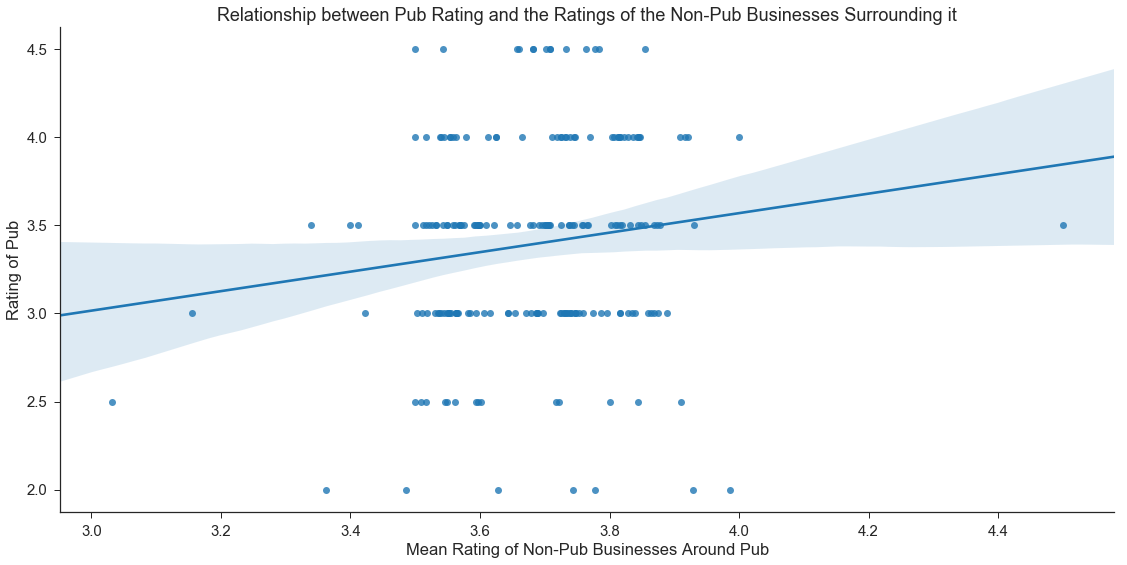

In [178]:
#Set style
sns.set_context("notebook", font_scale=1.5)
sns.set_style("ticks")

# Plot Data
g = sns.lmplot(x="mean_business_rating", y="rating", size=8, data=final_nonpubs_df,aspect=2.0)

# Plot Labels
plt.title("Relationship between Pub Rating and the Ratings of the Non-Pub Businesses Surrounding it")
plt.xlabel('Mean Rating of Non-Pub Businesses Around Pub')
plt.ylabel('Rating of Pub')

In [222]:
#toronto_businesses_df.neighborhood.unique()

In [221]:
#pd.value_counts(pubs_df['neighborhood'].values, sort=False)

## Looking at Pub Ratings in UofT and Downtown Core

In [182]:
uoft_df = toronto_businesses_df[toronto_businesses_df['neighborhood'] == 'University of Toronto' ]

In [223]:
uoft_pubs_df = pd.DataFrame()
uoft_notpubs_df = pd.DataFrame()

for lst in uoft_df['categories']:
    if "u'Pubs'" not in lst:
        uoft_notpubs_df = uoft_notpubs_df.append(uoft_df[uoft_df['categories'] == lst])
        
for lst in uoft_df['categories']:
    if "u'Pubs'" in lst:
        uoft_pubs_df = uoft_pubs_df.append(uoft_df[uoft_df['categories'] == lst])
        

uoft_pubs_df =uoft_pubs_df.drop_duplicates(['name','index_no'], keep='last')

In [212]:
final_uotnonpubs_df = pd.DataFrame()

def haversine(x):
    
    global uoft_notpubs_df
    global final_uotnonpubs_df
    
    # Initialize empty DataFrame
    df = pd.DataFrame()
    measure_1 = pd.DataFrame()
        
    # Calculate the latitudes, longitudes:
    df['LAT_rad'], df['LON_rad'] = np.radians(uoft_notpubs_df['latitude']), np.radians(uoft_notpubs_df['longitude'])
    df['dLON'] = df['LON_rad'] - math.radians(x['longitude'])
    df['dLAT'] = df['LAT_rad'] - math.radians(x['latitude'])

    # Use Haversine's formula
    uoft_notpubs_df['distance'] = 6367 * 2 * np.arcsin(np.sqrt(np.sin(df['dLAT']/2)**2 + math.cos(math.radians(37.2175900)) * np.cos(df['LAT_rad']) * np.sin(df['dLON']/2)**2))
   
    # Only consider pubs within a distance of 1 km of the chosen pub
    measure_1 = uoft_notpubs_df
    measure_1 = measure_1.loc[(uoft_notpubs_df['distance'] > 0.0) & (uoft_notpubs_df['distance'] <=1.5)]
    
    # Calculate the mean rating of the surrounding pubs
    mean_rating = measure_1['stars'].mean()
    density = (measure_1['stars'].count())/ (2*math.pi*1.0*1.0)

    final_uotnonpubs_df = final_uotnonpubs_df.append({'name': x['name'].item(), 'rating': x['stars'].item(), 'mean_business_rating': mean_rating, "density": density}, ignore_index=True)
    return final_uotnonpubs_df


for line in uoft_pubs_df['index_no']:
    x = uoft_pubs_df.loc[uoft_pubs_df['index_no'] == line]
    haversine(x)


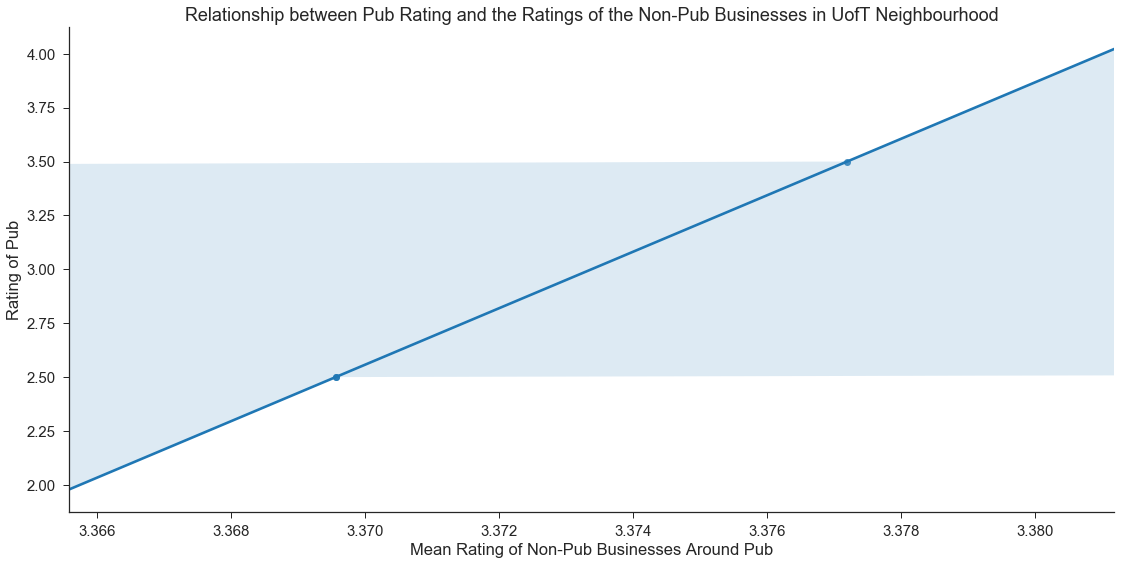

In [220]:
#Set style
sns.set_context("notebook", font_scale=1.5)
sns.set_style("ticks")

# Plot Data
g = sns.lmplot(x="mean_business_rating", y="rating", size=8, data=final_uotnonpubs_df,aspect=2.0)

# Plot Labels
plt.title("Relationship between Pub Rating and the Ratings of the Non-Pub Businesses in UofT Neighbourhood")
plt.xlabel('Mean Rating of Non-Pub Businesses Around Pub')
plt.ylabel('Rating of Pub')

In [184]:
downtown_df = toronto_businesses_df[toronto_businesses_df['neighborhood'] == 'Downtown Core' ]

In [224]:
downtown_pubs_df = pd.DataFrame()
downtown_notpubs_df = pd.DataFrame()

for lst in downtown_df['categories']:
    if "u'Pubs'" not in lst:
        downtown_notpubs_df = downtown_notpubs_df.append(downtown_df[downtown_df['categories'] == lst])
        
for lst in downtown_df['categories']:
    if "u'Pubs'" in lst:
        downtown_pubs_df = downtown_pubs_df.append(downtown_df[downtown_df['categories'] == lst])
        

downtown_pubs_df =downtown_pubs_df.drop_duplicates(['name','index_no'], keep='last')

In [217]:
final_downtown_nonpubs_df = pd.DataFrame()

def haversine(x):
    
    global downtown_notpubs_df
    global final_downtown_nonpubs_df
    
    # Initialize empty DataFrame
    df = pd.DataFrame()
    measure_1 = pd.DataFrame()
        
    # Calculate the latitudes, longitudes:
    df['LAT_rad'], df['LON_rad'] = np.radians(downtown_notpubs_df['latitude']), np.radians(downtown_notpubs_df['longitude'])
    df['dLON'] = df['LON_rad'] - math.radians(x['longitude'])
    df['dLAT'] = df['LAT_rad'] - math.radians(x['latitude'])

    # Use Haversine's formula
    downtown_notpubs_df['distance'] = 6367 * 2 * np.arcsin(np.sqrt(np.sin(df['dLAT']/2)**2 + math.cos(math.radians(37.2175900)) * np.cos(df['LAT_rad']) * np.sin(df['dLON']/2)**2))
   
    # Only consider pubs within a distance of 1 km of the chosen pub
    measure_1 = downtown_notpubs_df
    measure_1 = measure_1.loc[(downtown_notpubs_df['distance'] > 0.0) & (downtown_notpubs_df['distance'] <=1.5)]
    
    # Calculate the mean rating of the surrounding pubs
    mean_rating = measure_1['stars'].mean()
    density = (measure_1['stars'].count())/ (2*math.pi*1.0*1.0)

    final_downtown_nonpubs_df = final_downtown_nonpubs_df.append({'name': x['name'].item(), 'rating': x['stars'].item(), 'mean_business_rating': mean_rating, "density": density}, ignore_index=True)
    return final_downtown_nonpubs_df


for line in downtown_pubs_df['index_no']:
    x = downtown_pubs_df.loc[downtown_pubs_df['index_no'] == line]
    haversine(x)


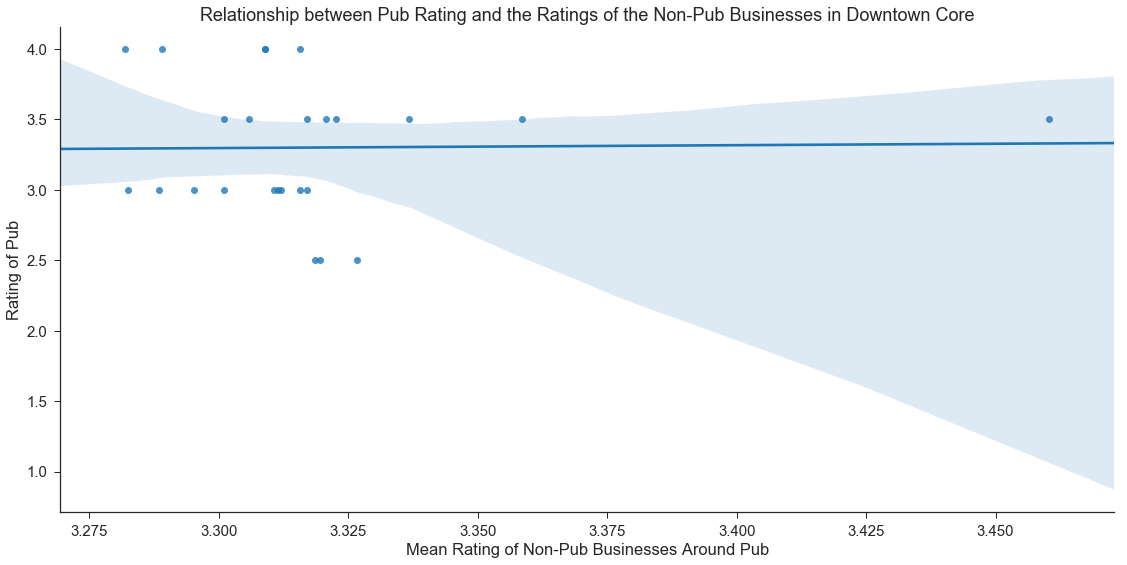

In [219]:
#Set style
sns.set_context("notebook", font_scale=1.5)
sns.set_style("ticks")

# Plot Data
g = sns.lmplot(x="mean_business_rating", y="rating", size=8, data=final_downtown_nonpubs_df,aspect=2.0)

# Plot Labels
plt.title("Relationship between Pub Rating and the Ratings of the Non-Pub Businesses in Downtown Core")
plt.xlabel('Mean Rating of Non-Pub Businesses Around Pub')
plt.ylabel('Rating of Pub')